In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import spacy
from spacy.pipeline import EntityRuler
from collections import Counter
from sklearn.metrics import classification_report
import seaborn as sns
from tqdm import tqdm
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

from src.patterns import ORG_KEYWORDS, ORG_SUFFIXES, BAD_ORG_TOKENS, COUNTRIES, CITIES, STATES_USA

c:\Users\Пользователь\Desktop\учеба\Компьютерная лингвистика Досов\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 3.1 MB/s eta 0:00:05
     - -------------------------------------- 0.4/12.8 MB 3.6 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 5.6 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.8 MB 7.0 MB/s eta 0:00:02
     ---- ----------------------------------- 1.5/12.8 MB 6.0 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.8 MB 8.4 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.8 MB 8.6 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 8.4 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 8.9 MB/s eta 0:00:02
     ------------- -------------------------- 4.3/12.8 MB 8.9 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 8.9 MB/s


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
dataset = load_dataset(
    "tner/ontonotes5",
    data_dir="ontonotes5",              
    revision="refs/convert/parquet"  
)

In [4]:
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [5]:
LABEL_TO_ID = {
    "O": 0,
    "B-CARDINAL": 1,
    "B-DATE": 2,
    "I-DATE": 3,
    "B-PERSON": 4,
    "I-PERSON": 5,
    "B-NORP": 6,
    "B-GPE": 7,
    "I-GPE": 8,
    "B-LAW": 9,
    "I-LAW": 10,
    "B-ORG": 11,
    "I-ORG": 12, 
    "B-PERCENT": 13,
    "I-PERCENT": 14, 
    "B-ORDINAL": 15, 
    "B-MONEY": 16, 
    "I-MONEY": 17, 
    "B-WORK_OF_ART": 18, 
    "I-WORK_OF_ART": 19, 
    "B-FAC": 20, 
    "B-TIME": 21, 
    "I-CARDINAL": 22, 
    "B-LOC": 23, 
    "B-QUANTITY": 24, 
    "I-QUANTITY": 25, 
    "I-NORP": 26, 
    "I-LOC": 27, 
    "B-PRODUCT": 28, 
    "I-TIME": 29, 
    "B-EVENT": 30,
    "I-EVENT": 31,
    "I-FAC": 32,
    "B-LANGUAGE": 33,
    "I-PRODUCT": 34,
    "I-ORDINAL": 35,
    "I-LANGUAGE": 36
}

In [6]:
id2label = {v: k for k, v in LABEL_TO_ID.items()}

In [ ]:
def ids_to_labels(tag_ids, id2label_map):
    return [id2label_map[i] for i in tag_ids]

def prepare_dataframe(split, id2label_map):
    rows = []
    total = len(split)
    for item in split.select(range(total)):
        tokens = item["tokens"]
        tag_ids = item["tags"]
        labels = ids_to_labels(tag_ids, id2label_map)
        text = " ".join(tokens)
        rows.append({"tokens": tokens, "labels": labels, "text": text})
    return pd.DataFrame(rows)

df_train = prepare_dataframe(train, id2label)
print("Пример строки DataFrame:")
print(df_train.iloc[0])

Пример строки DataFrame:
tokens    [People, start, their, own, businesses, for, m...
labels                          [O, O, O, O, O, O, O, O, O]
text      People start their own businesses for many rea...
Name: 0, dtype: object


In [ ]:
def extract_entities_from_bio(tokens, labels):
    ents = []
    current_tokens = []
    current_label = None
    start_idx = None

    for i, (tok, lab) in enumerate(zip(tokens, labels)):
        if lab == "O" or lab == "O\n" or lab is None:
            if current_tokens:
                ent_text = " ".join(current_tokens)
                ents.append((ent_text, current_label, start_idx, i))
                current_tokens = []
                current_label = None
                start_idx = None
            continue

        if lab.startswith("B-"):
            if current_tokens:
                ent_text = " ".join(current_tokens)
                ents.append((ent_text, current_label, start_idx, i))

            current_tokens = [tok]
            current_label = lab.split("-", 1)[1]  
            start_idx = i
        elif lab.startswith("I-"):

            typ = lab.split("-", 1)[1]
            if current_label == typ and current_tokens:
                current_tokens.append(tok)
            else:

                current_tokens = [tok]
                current_label = typ
                start_idx = i
        else:

            if current_tokens:
                ent_text = " ".join(current_tokens)
                ents.append((ent_text, current_label, start_idx, i))
            current_tokens = []
            current_label = None
            start_idx = None


    if current_tokens:
        ent_text = " ".join(current_tokens)
        ents.append((ent_text, current_label, start_idx, len(tokens)))

    return ents



In [ ]:
sample_tokens = df_train.loc[20, "tokens"]
sample_labels = df_train.loc[20, "labels"]
print("Tokens:", sample_tokens)
print("Labels:", sample_labels)
print("Извлечённые сущности:", extract_entities_from_bio(sample_tokens, sample_labels))

Tokens: ['``', 'It', "'s", 'very', 'costly', 'and', 'time', '-', 'consuming', ',', "''", 'says', 'Phil', 'Rosen', ',', 'a', 'partner', 'in', 'Fleet', '&', 'Leasing', 'Management', 'Inc.', ',', 'a', 'Boston', 'car', '-', 'leasing', 'company', '.']
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O']
Извлечённые сущности: [('Phil Rosen', 'PERSON', 12, 14), ('Fleet & Leasing Management Inc.', 'ORG', 18, 23), ('Boston', 'GPE', 25, 26)]


In [ ]:

def all_entities_from_df(df):
    all_ents = []
    for _, row in df.iterrows():
        ents = extract_entities_from_bio(row["tokens"], row["labels"])
        for text, typ, s, e in ents:
            all_ents.append((text, typ))
    return all_ents

all_ents = all_entities_from_df(df_train)
print(f"Всего извлечено сущностей (на {len(df_train)} примерах): {len(all_ents)}")

Всего извлечено сущностей (на 59924 примерах): 81828


In [11]:
type_counts = Counter([typ for _, typ in all_ents])
print("Распределение типов сущностей (ТОП-20):")
for typ, cnt in type_counts.most_common(20):
    print(f"{typ}: {cnt}")

Распределение типов сущностей (ТОП-20):
PERSON: 15429
GPE: 15405
ORG: 12820
DATE: 10922
CARDINAL: 7367
NORP: 6870
MONEY: 2434
PERCENT: 1763
ORDINAL: 1640
LOC: 1514
TIME: 1233
WORK_OF_ART: 974
FAC: 860
EVENT: 748
QUANTITY: 657
PRODUCT: 606
LANGUAGE: 304
LAW: 282


In [12]:
sorted([x for x in all_ents if x[1] in ('ORG')], key=lambda x: x[1])

[('Journal', 'ORG'),
 ('TechDesign International Inc.', 'ORG'),
 ('the Federal Communications Commission', 'ORG'),
 ('Dooling & Co.', 'ORG'),
 ('Fleet & Leasing Management Inc.', 'ORG'),
 ('Impco Inc.', 'ORG'),
 ('Impco', 'ORG'),
 ('Eastern Reproduction Corp.', 'ORG'),
 ('Brown Capital Management Inc.', 'ORG'),
 ('Professional Agricultural Management Inc.', 'ORG'),
 ('Lee Liu & Tong Advertising Inc.', 'ORG'),
 ('the Trinity Repertory Theater', 'ORG'),
 ('Trinity Rep', 'ORG'),
 ('Trinity', 'ORG'),
 ('Trinity', 'ORG'),
 ('Trinity Rep', 'ORG'),
 ('Banxquote Money Markets', 'ORG'),
 ('Banxquote', 'ORG'),
 ('Treasury', 'ORG'),
 ('Banxquote', 'ORG'),
 ('Chase Manhattan Bank', 'ORG'),
 ('Bank of America', 'ORG'),
 ('Lion Nathan Ltd.', 'ORG'),
 ('Pepsi - Cola', 'ORG'),
 ('Foreign Investment Review Board', 'ORG'),
 ('Cadbury Schweppes Australia Ltd.', 'ORG'),
 ('Pepsi', 'ORG'),
 ('Lion Nathan', 'ORG'),
 ('PepsiCola Australia', 'ORG'),
 ('PepsiCo Inc.', 'ORG'),
 ('Cadbury Schweppes', 'ORG'),
 ('

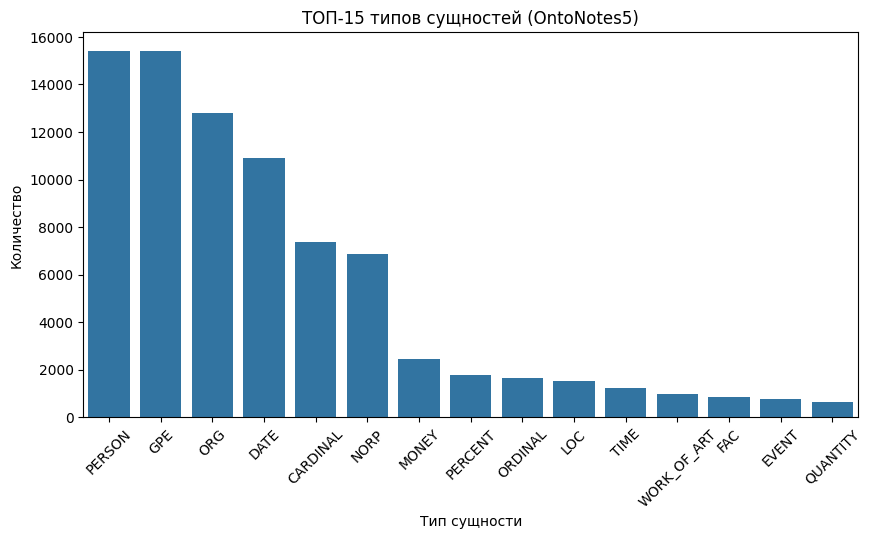

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(x=[t for t,_ in type_counts.most_common(15)], y=[c for _,c in type_counts.most_common(15)])
plt.xticks(rotation=45)
plt.title("ТОП-15 типов сущностей (OntoNotes5)")
plt.ylabel("Количество")
plt.xlabel("Тип сущности")
plt.show()

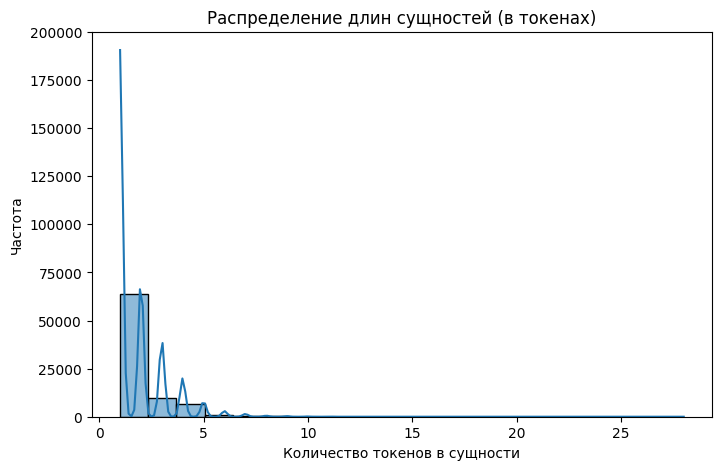

In [14]:
entity_lengths = [len(text.split()) for text, _ in all_ents]

plt.figure(figsize=(8,5))
sns.histplot(entity_lengths, bins=20, kde=True)
plt.title("Распределение длин сущностей (в токенах)")
plt.xlabel("Количество токенов в сущности")
plt.ylabel("Частота")
plt.show()

In [15]:
print("Средняя длина сущности (в токенах):", np.mean(entity_lengths))
print("Медиана длины сущности:", np.median(entity_lengths))
print("Макс. длина сущности:", np.max(entity_lengths))


Средняя длина сущности (в токенах): 1.8249376741457692
Медиана длины сущности: 1.0
Макс. длина сущности: 28


In [16]:
def print_examples_with_entities(df, n=10):
    printed = 0
    for _, row in df.iterrows():
        ents = extract_entities_from_bio(row["tokens"], row["labels"])
        if ents:
            print("TEXT:", row["text"])
            print("ENTITIES:", ents)
            print("-" * 80)
            printed += 1
            if printed >= n:
                break

print_examples_with_entities(df_train, n=30)

TEXT: But a chance to fill out sales - tax records is rarely one of them .
ENTITIES: [('one', 'CARDINAL', 12, 13)]
--------------------------------------------------------------------------------
TEXT: Last week , Sen. Malcolm Wallop -LRB- R. , Wyo . -RRB- held hearings on a bill to strengthen an existing law designed to reduce regulatory hassles for small businesses .
ENTITIES: [('Last week', 'DATE', 0, 2), ('Malcolm Wallop', 'PERSON', 4, 6), ('R.', 'NORP', 7, 8), ('Wyo .', 'GPE', 9, 11)]
--------------------------------------------------------------------------------
TEXT: `` A great many federal regulations are meant for larger entities and do n't really apply to small businesses , '' says Marian Jacob , a legislative aide to Sen. Wallop .
ENTITIES: [('Marian Jacob', 'PERSON', 22, 24), ('Wallop', 'PERSON', 30, 31)]
--------------------------------------------------------------------------------
TEXT: Other lawmakers are busy trying to revive the recently lapsed Paperwork Reduction A

In [ ]:

words_with_types = []
for (text, typ) in all_ents:
    words_with_types.append((text, typ))

word_counts = Counter([w for w, typ in words_with_types])

print("ТОП-30 слов внутри сущностей:")
for w, c in word_counts.most_common(300):

    types_for_word = [typ for word, typ in words_with_types if word == w]

    most_common_type = Counter(types_for_word).most_common(1)[0][0]
    all_types = ', '.join(set(types_for_word))
    
    print(f"{w:20} {c:4} тип: {most_common_type}")

ТОП-30 слов внутри сущностей:
China                1014 тип: GPE
two                   998 тип: CARDINAL
one                   916 тип: CARDINAL
Taiwan                914 тип: GPE
first                 829 тип: ORDINAL
U.S.                  754 тип: GPE
today                 563 тип: DATE
US                    558 тип: GPE
Chinese               493 тип: NORP
Israeli               434 тип: NORP
three                 415 тип: CARDINAL
Japan                 393 тип: GPE
American              384 тип: NORP
Bush                  366 тип: PERSON
Iraq                  365 тип: GPE
Palestinian           349 тип: NORP
Japanese              310 тип: NORP
New York              284 тип: GPE
Israel                270 тип: GPE
Washington            266 тип: GPE
second                260 тип: ORDINAL
Xinhua News Agency    241 тип: ORG
Palestinians          229 тип: NORP
Taiwanese             229 тип: NORP
four                  217 тип: CARDINAL
Clinton               209 тип: PERSON
Hong Kong         

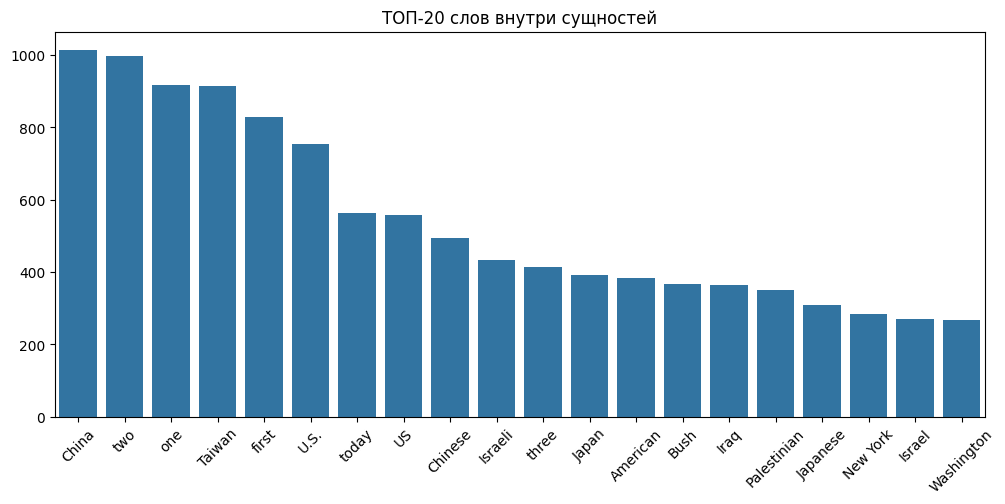

In [19]:
plt.figure(figsize=(12,5))
topn = 20
sns.barplot(x=[w for w,_ in word_counts.most_common(topn)], y=[c for _,c in word_counts.most_common(topn)])
plt.xticks(rotation=45)
plt.title("ТОП-20 слов внутри сущностей")
plt.show()

In [ ]:
from spacy.language import Language
import spacy

nlp = spacy.load("en_core_web_sm")
ruler = nlp.add_pipe("entity_ruler", before="ner")

# ---------- PERSON ----------
person_patterns = [
    # Имя + фамилия (2 токена)
    {
        "label": "PERSON",
        "pattern": [
            {"IS_TITLE": True, "LENGTH": {">=": 2}},
            {"IS_TITLE": True, "LENGTH": {">=": 2}}
        ]
    },
    # Полное имя с титулом
    {
        "label": "PERSON",
        "pattern": [
            {"LOWER": {"IN": ["dr", "mr", "mrs", "ms", "prof"]}},
            {"IS_TITLE": True, "LENGTH": {">=": 2}},
            {"IS_TITLE": True, "LENGTH": {">=": 2}, "OP": "?"}
        ]
    },
    {
        "label": "PERSON",
        "pattern": [
        {"IS_TITLE": True, "LENGTH": {">=": 3}},
        {"TEXT": "-", "OP": "?"},
        {"IS_TITLE": True, "LENGTH": {">=": 3}}
        ]
    }
]

# ---------- ORG ----------


org_patterns = [
    # Организации с суффиксами: OpenAI Inc., Microsoft Corporation
    {
        "label": "ORG",
        "pattern": [
            {"IS_TITLE": True, "LENGTH": {">=": 2}, "OP": "+"},
            {"LOWER": {"IN": [s.lower() for s in ORG_SUFFIXES]}}
        ]
    },
    # Названия с ключевыми словами: Bank of America
    {
        "label": "ORG",
        "pattern": [
            {"IS_TITLE": True, "LENGTH": {">=": 2}},
            {"LOWER": "of"},
            {"IS_TITLE": True, "LENGTH": {">=": 2}},
            {"LOWER": {"IN": [s.lower() for s in ORG_KEYWORDS]}, "OP": "+"}
        ]
    },
    {
        "label": "ORG",
        "pattern": [
            {"LOWER": "the"},
            {"LOWER": {"IN": [s.lower() for s in ORG_KEYWORDS]}},
            {"IS_TITLE": True, "LENGTH": {">=": 2}, "OP": "+"},
            {"LOWER": {"IN": [s.lower() for s in ORG_SUFFIXES]}, "OP": "+"}
        ]
    },
    {
        "label": "ORG",
        "pattern": [
            {"LOWER": "the"},
            {"IS_TITLE": True, "LENGTH": {">=": 2}},
            {"LOWER": "of"},
            {"IS_TITLE": True, "LENGTH": {">=": 2}, "OP": "+"},
            {"LOWER": {"IN": [s.lower() for s in ORG_SUFFIXES]}, "OP": "+"}
        ]
    },
    {
        "label": "ORG",
        "pattern": [
            {"LOWER": "the"},
            {"IS_TITLE": True, "LENGTH": {">=": 2}, "OP": "+"},
            {"LOWER": {"IN": [s.lower() for s in ORG_SUFFIXES]}}
        ]
    },

]

# ---------- GPE ----------
gpe_patterns = [
    {"label": "GPE", "pattern": [{"LOWER": {"IN": [c.lower() for c in COUNTRIES]}}]},
    {"label": "GPE", "pattern": [{"LOWER": {"IN": [s.lower() for s in STATES_USA]}}]},
    {"label": "GPE", "pattern": [{"LOWER": {"IN": [c.lower() for c in CITIES]}}]},
    {"label": "GPE", "pattern": [{"LOWER": "united"}, {"LOWER": {"IN": ["states", "kingdom"]}}]}
]

# ---------- DATE ----------
date_patterns = [
    {"label": "DATE", "pattern": [{"LIKE_NUM": True, "LENGTH": 4}]},
    {"label": "DATE", "pattern": [{"LOWER": {"IN": ["last", "next", "this"]}}, {"LOWER": {"IN": ["week", "month", "year", "quarter"]}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"IN": ["January", "February", "March", "April", "May", "June",
                                                 "July", "August", "September", "October", "November", "December"]}},
                                  {"LIKE_NUM": True}]}
]

# ---------- Сбор всех паттернов ----------
patterns = []
patterns.extend(gpe_patterns)    
patterns.extend(org_patterns)    
patterns.extend(person_patterns) 
patterns.extend(date_patterns)   

ruler.add_patterns(patterns)

# ---------- Фильтр сущностей ----------
@Language.component("strict_entity_filter")
def strict_entity_filter(doc):
    new_ents = []
    for ent in doc.ents:
        text = ent.text.strip().lower()

        # Общие фильтры
        if len(text) < 3:
            continue
        if text in {"the", "a", "an", "in", "on", "at", "to", "by", "of"}:
            continue

        # PERSON фильтры
        if ent.label_ == "PERSON":
            if len(ent) == 1 and text in {"dr", "mr", "mrs", "ms", "president"}:
                continue
            if text in {"i", "you", "he", "she", "it", "we", "they"}:
                continue

        # ORG фильтры
        if ent.label_ == "ORG":
            # Убираем короткие или служебные слова
            if len(ent.text.split()) == 1 and len(ent.text) < 4:
                continue
            if text in {"the", "a", "an", "of", "to", "by", "for", "and"}:
                continue

        new_ents.append(ent)

    doc.ents = new_ents
    return doc

nlp.add_pipe("strict_entity_filter", last=True)


<function __main__.strict_entity_filter(doc)>

In [ ]:



def apply_rule_based_ner(text):
    """Применяет spaCy pipeline с нашими правилами и возвращает сущности."""
    doc = nlp(text)
    return [(ent.text, ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]


sample_df = df_train #.sample(10000, random_state=42)

predicted_entities = []
gold_entities = []

results = []
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    pred_ents = apply_rule_based_ner(row["text"])
    predicted_entities.append(pred_ents)

    # Gold (истинные сущности)
    gold_ents = extract_entities_from_bio(row["tokens"], row["labels"])
    gold_entities.append(gold_ents)


def entities_to_bio(tokens, entities):

    tags = ["O"] * len(tokens)
    for ent_text, label, start_char, end_char in entities:
        joined = " ".join(tokens)
        for i, tok in enumerate(tokens):
            if ent_text.startswith(tok) or tok in ent_text.split():
                if tags[i] == "O":
                    tags[i] = "B-" + label
                else:
                    tags[i] = "I-" + label
    return tags

gold_tags_all, pred_tags_all = [], []

for i, row in enumerate(sample_df.itertuples()):
    gold_tags = row.labels
    pred_tags = entities_to_bio(row.tokens, predicted_entities[i])
    gold_tags_all.extend(gold_tags)
    pred_tags_all.extend(pred_tags)

valid_labels = [t for t in gold_tags_all if t != "O"]
print("\nОтчёт по rule-based NER (по токенам):\n")
print(classification_report(gold_tags_all, pred_tags_all, labels=list(set(valid_labels))[:10], zero_division=0))

100%|██████████| 59924/59924 [05:12<00:00, 191.47it/s]



Отчёт по rule-based NER (по токенам):

              precision    recall  f1-score   support

       I-ORG       0.30      0.04      0.08     18246
  B-CARDINAL       0.59      0.65      0.62      7355
       I-LOC       0.06      0.00      0.01      1395
   I-ORDINAL       0.00      0.00      0.00         5
     I-EVENT       0.27      0.01      0.01      1605
   B-ORDINAL       0.85      0.86      0.86      1640
      I-DATE       0.43      0.06      0.11     13333
    I-PERSON       0.10      0.03      0.05     11147
     B-MONEY       0.32      0.74      0.45      2411
       I-GPE       0.01      0.00      0.00      3679

   micro avg       0.40      0.16      0.23     60816
   macro avg       0.29      0.24      0.22     60816
weighted avg       0.32      0.16      0.17     60816



Precision, Recall, F1 по сущностям:

              precision    recall  f1-score   support

    CARDINAL       0.47      0.54      0.50      7367
        DATE       0.14      0.35      0.20     10922
       EVENT       0.15      0.10      0.12       748
         FAC       0.37      0.14      0.21       860
         GPE       0.87      0.72      0.79     15405
    LANGUAGE       0.85      0.71      0.77       304
         LAW       0.18      0.20      0.19       282
         LOC       0.61      0.34      0.44      1514
       MONEY       0.09      0.22      0.13      2434
        NORP       0.91      0.76      0.83      6870
     ORDINAL       0.85      0.91      0.88      1640
         ORG       0.14      0.25      0.18     12820
     PERCENT       0.15      0.27      0.20      1763
      PERSON       0.14      0.46      0.21     15429
     PRODUCT       0.31      0.49      0.38       606
    QUANTITY       0.04      0.09      0.05       657
        TIME       0.12      0.28      0.17 

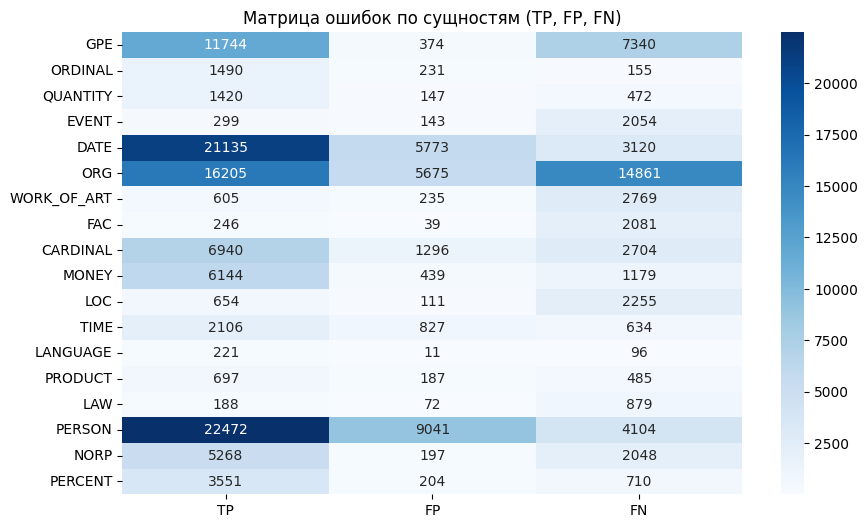

In [ ]:

gold_tags_seq = [row.labels for row in sample_df.itertuples()]
pred_tags_seq = [entities_to_bio(row.tokens, predicted_entities[i]) for i, row in enumerate(sample_df.itertuples())]

print("Precision, Recall, F1 по сущностям:\n")
print(seq_classification_report(gold_tags_seq, pred_tags_seq, zero_division=0))


entity_types = list(set([tag[2:] for doc in gold_tags_seq for tag in doc if tag != "O"]))
TP = defaultdict(int)
FP = defaultdict(int)
FN = defaultdict(int)

for gold_doc, pred_doc in zip(gold_tags_seq, pred_tags_seq):
    for g, p in zip(gold_doc, pred_doc):
        g_type = g[2:] if g != "O" else None
        p_type = p[2:] if p != "O" else None

        if g_type == p_type and g_type is not None:
            TP[g_type] += 1
        elif g_type is None and p_type is not None:
            FP[p_type] += 1
        elif g_type is not None and p_type != g_type:
            FN[g_type] += 1

error_matrix = pd.DataFrame(index=entity_types, columns=["TP","FP","FN"])
for e in entity_types:
    error_matrix.loc[e] = [TP.get(e,0), FP.get(e,0), FN.get(e,0)]

plt.figure(figsize=(10,6))
sns.heatmap(error_matrix.astype(int), annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок по сущностям (TP, FP, FN)")
plt.show()

In [ ]:
# False Negatives (не нашли сущность)
fn_examples = []
for i, (gold_doc, pred_doc, row) in enumerate(zip(gold_tags_seq, pred_tags_seq, sample_df.itertuples())):
    for t_gold, t_pred, tok in zip(gold_doc, pred_doc, row.tokens):
        if t_gold != "O" and t_pred == "O":
            fn_examples.append((tok, t_gold))

fn_pairs = [(tok, t_gold[2:]) for tok, t_gold in fn_examples]

fn_pair_counts = Counter(fn_pairs)
fn_by_type = Counter([ent_type for _, ent_type in fn_pairs])

print("🔹 False Negatives по токенам и типам (топ-50):")
for (tok, ent_type), count in fn_pair_counts.most_common(10):
    print(f"{tok:<20} → {ent_type:<10} ({count})")

print("\n🔸 False Negatives по типам сущностей:")
for ent_type, count in fn_by_type.most_common(10):
    print(f"{ent_type:<10} — {count}")


🔹 False Negatives по токенам и типам (топ-50):
-                    → PERSON     (702)
the                  → ORG        (590)
US                   → GPE        (514)
's                   → ORG        (306)
the                  → GPE        (284)
the                  → LOC        (284)
's                   → PERSON     (280)
of                   → ORG        (277)
%                    → PERCENT    (223)
the                  → FAC        (189)

🔸 False Negatives по типам сущностей:
ORG        — 5125
PERSON     — 3455
DATE       — 2299
CARDINAL   — 1598
GPE        — 1362
WORK_OF_ART — 1036
MONEY      — 636
EVENT      — 627
FAC        — 463
LOC        — 446


In [ ]:

fp_examples = []
for i, (gold_doc, pred_doc, row) in enumerate(zip(gold_tags_seq, pred_tags_seq, sample_df.itertuples())):
    for t_gold, t_pred, tok in zip(gold_doc, pred_doc, row.tokens):
        if t_gold == "O" and t_pred != "O":
            fp_examples.append((tok, t_pred))
fp_counts = Counter([tok for tok, t_pred in fp_examples])

fp_pairs = [(tok, t_pred[2:]) for tok, t_pred in fp_examples] 


fp_pair_counts = Counter(fp_pairs)


fp_by_type = Counter([ent_type for _, ent_type in fp_pairs])

print("🔹 False Positives по токенам и типам (топ-50):")
for (tok, ent_type), count in fp_pair_counts.most_common(10):
    print(f"{tok:<20} → {ent_type:<10} ({count})")

print("\n🔸 False Positives по типам сущностей:")
for ent_type, count in fp_by_type.most_common(10):
    print(f"{ent_type:<10} — {count}")

🔹 False Positives по токенам и типам (топ-50):
the                  → ORG        (2757)
the                  → DATE       (1989)
Mr.                  → PERSON     (1543)
The                  → PERSON     (659)
President            → PERSON     (627)
to                   → DATE       (445)
a                    → DATE       (417)
as                   → ORG        (411)
of                   → ORG        (400)
of                   → DATE       (345)

🔸 False Positives по типам сущностей:
PERSON     — 9041
DATE       — 5773
ORG        — 5675
CARDINAL   — 1296
TIME       — 827
MONEY      — 439
GPE        — 374
WORK_OF_ART — 235
ORDINAL    — 231
PERCENT    — 204
